In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
os.chdir ("/content/drive/My Drive/content/drive/My Drive/Skincancer")
!ls

test  train  valid


In [ ]:
labels = ['benign', 'malignant']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
test = get_training_data('test')
val = get_training_data('valid')
train = get_training_data('train')

<ipython-input-4-e4acdba92f00>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
l = ""
for i in train:
    if(i[1] == 0):
      l="Malignant"
    else:
      l="Benign"
sns.set_style('darkgrid')

Text(0.5, 1.0, 'malignant')

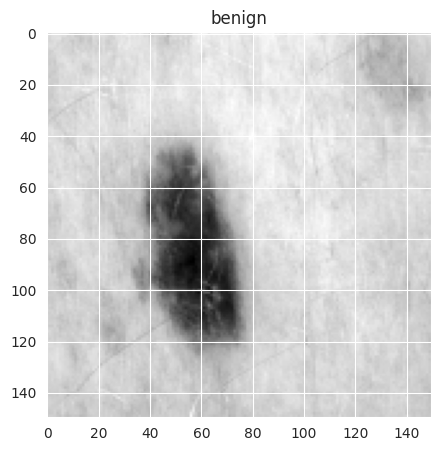

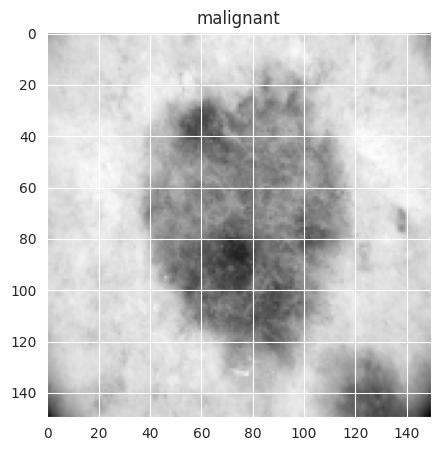

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)


datagen.fit(x_train)

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(512 , (4,4) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 30 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/30
83/83 [==============================] - 24s 119ms/step - loss: 1.0795 - accuracy: 0.5842 - val_loss: 2.3140 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - 7s 90ms/step - loss: 0.6391 - accuracy: 0.6461 - val_loss: 0.9923 - val_accuracy: 0.4545 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.5883 - accuracy: 0.7113
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 [==============================] - 8s 94ms/step - loss: 0.5883 - accuracy: 0.7113 - val_loss: 20.5817 - val_accuracy: 0.4545 - lr: 0.0010
Epoch 4/30
83/83 [==============================] - 11s 127ms/step - loss: 0.4744 - accuracy: 0.7735 - val_loss: 9.9877 - val_accuracy: 0.4348 - lr: 3.0000e-04
Epoch 5/30
83/83 [==============================] - 7s 89ms/step - loss: 0.4725 - accuracy: 0.7712 - val_loss: 0.8449 - val_accuracy: 0.5667 - lr: 3.0000e-04
Epoch 6/30
83/83 [==============================] - 9s 107

In [ ]:
print("Testing Loss")
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")
print("Training Loss")
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0])
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Validation Loss")
print("Loss of the model is - " , model.evaluate(x_val,y_val)[0])
print("Accuracy of the model is - " , model.evaluate(x_val,y_val)[1]*100 , "%")

Testing Loss
21/21 [==============================] - 0s 14ms/step - loss: 0.4291 - accuracy: 0.8121
Loss of the model is -  0.4291045069694519
21/21 [==============================] - 0s 12ms/step - loss: 0.4291 - accuracy: 0.8121
Accuracy of the model is -  81.21212124824524 %
Training Loss
83/83 [==============================] - 1s 11ms/step - loss: 0.3678 - accuracy: 0.8289
Loss of the model is -  0.36784428358078003
83/83 [==============================] - 1s 11ms/step - loss: 0.3678 - accuracy: 0.8289
Accuracy of the model is -  82.89074301719666 %
Validation Loss
21/21 [==============================] - 0s 11ms/step - loss: 0.4291 - accuracy: 0.8121
Loss of the model is -  0.4291045069694519
21/21 [==============================] - 0s 11ms/step - loss: 0.4291 - accuracy: 0.8121
Accuracy of the model is -  81.21212124824524 %


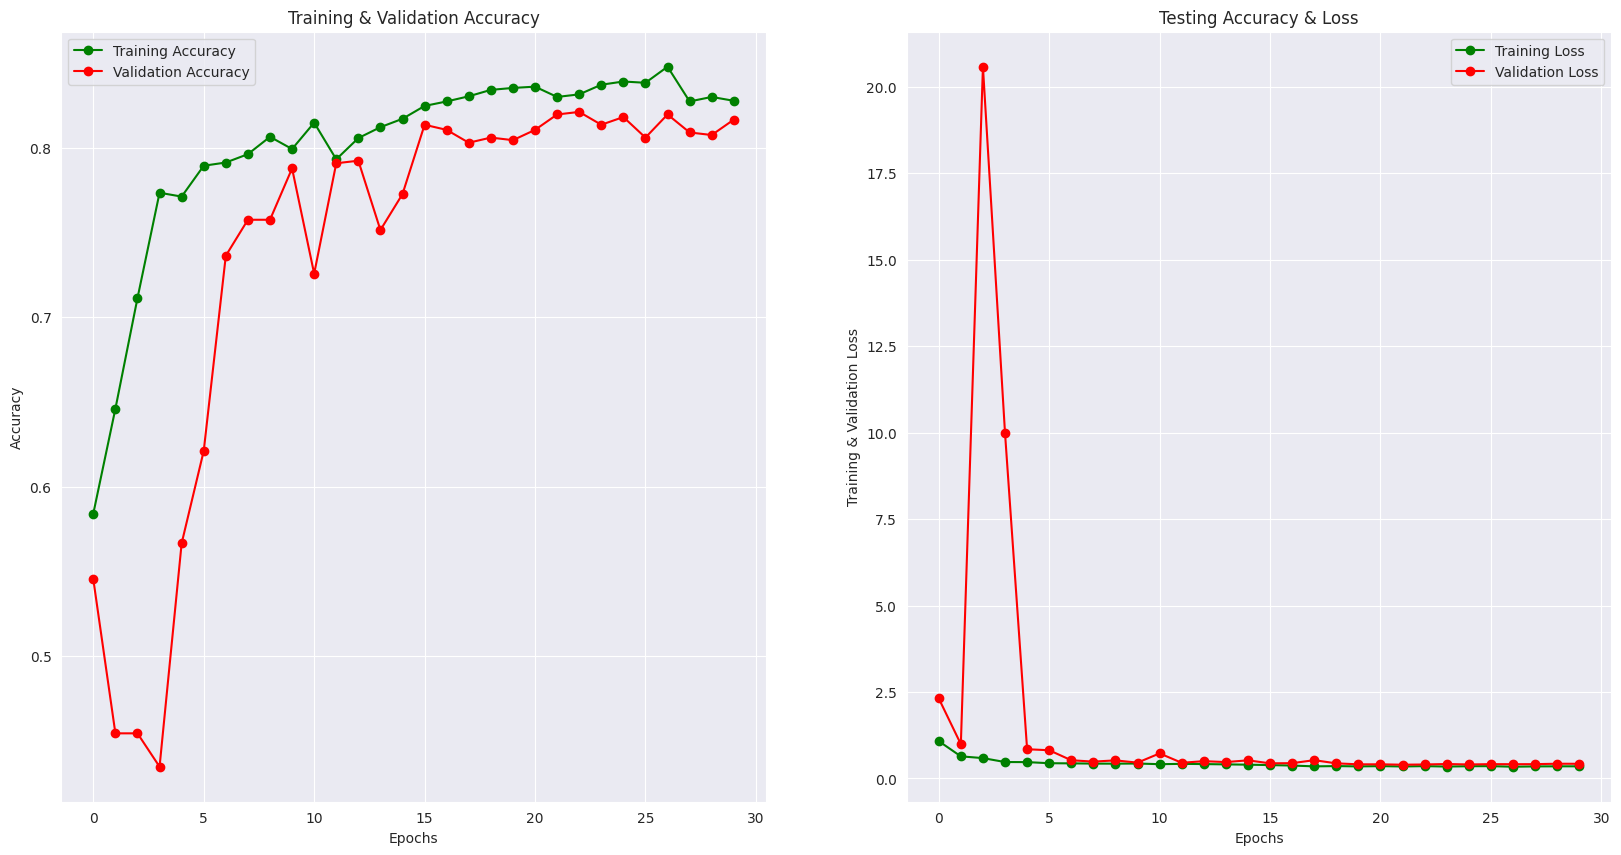

In [ ]:
epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

21/21 [==============================] - 0s 11ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['MALIGNANT(Class 0)','BENIGN (Class 1)']))

                    precision    recall  f1-score   support

MALIGNANT(Class 0)       0.79      0.89      0.84       360
  BENIGN (Class 1)       0.85      0.71      0.78       300

          accuracy                           0.81       660
         macro avg       0.82      0.80      0.81       660
      weighted avg       0.82      0.81      0.81       660



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[322,  38],
       [ 86, 214]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

<ipython-input-26-bc56ccdb96c4>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


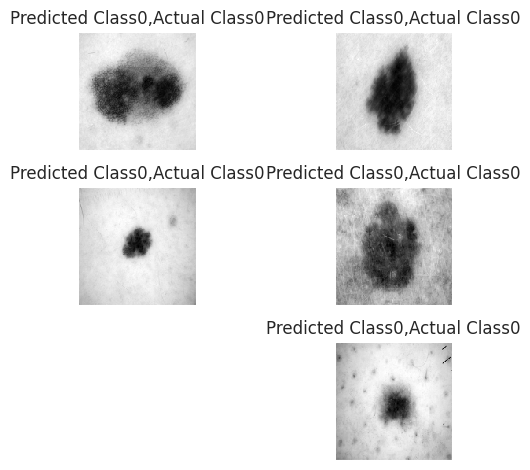

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class{},Actual Class{}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

<ipython-input-27-837baf81a77f>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


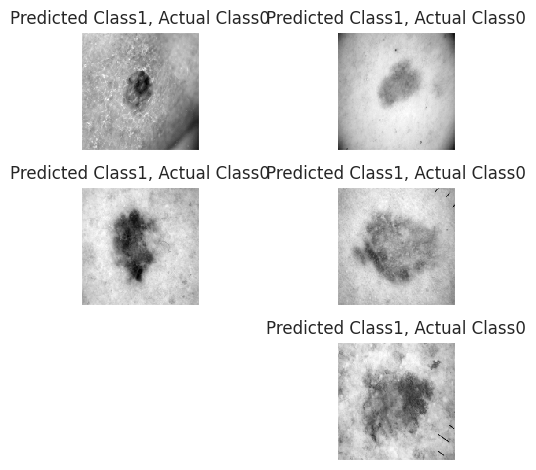

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class{}, Actual Class{}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1